In [1]:
import pandas as pd
import numpy as np

In [2]:
def sigmoid(Z):
    
    sig= 1 / ( 1 + np.exp(-Z))

    return sig , Z

In [3]:
def relu(Z):
    
    A = np.maximum(0,Z)
    
    return A, Z


In [4]:
def tanh(Z):
    
    A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z)+np.exp(-Z))
    
    return A, Z

In [5]:
def initialize_parameters(layer_dims):
    
    parameters={}
    
    np.random.seed(1)
    
    for l in range(1,len(layer_dims)):
        parameters["W"+str(l)]= np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters["b"+str(l)]= np.zeros((layer_dims[l],1))
        
    return parameters

In [6]:
def linear_forward(A,W,b):
    
    Z=np.dot(W , A)+ b
    
    cache= (A,W,b)
    
    return Z, cache

In [7]:
def linear_act_forward(A_prev, W, b, act_function):
    
    if act_function=="sigmoid":
        Z , linear_cache = linear_forward(A_prev,W,b)
        A , activation_cache = sigmoid(Z)
        
    elif act_function=="relu":
        Z , linear_cache= linear_forward(A_prev,W,b)
        A , activation_cache = relu(Z)
        
    elif act_function=="tanh":
        Z , linear_cache = linear_forward(A_prev,W,b)
        A , activation_cache = tanh(Z)
        
    cache = (linear_cache,activation_cache)
    
    return A , cache
    

In [8]:
def linear_model(X, parameters):
    
    caches=[]
    
    A = X
    L = len(parameters) // 2
    
    for l in range(1,L):
        A_prev=A
        W = parameters["W"+str(l)]
        b= parameters ["b"+str(l)]
        A , cache = linear_act_forward(A_prev,W,b, act_function)
        caches.append(cache)
    
    W=parameters["W"+str(L)]
    b=parameters["b"+str(L)]
    AL , cache = linear_act_forward(A,W,b,act_function="sigmoid")
    caches.append(cache)
    
    return AL, caches
    

In [9]:
def compute_cost(AL, Y):
    
    m=Y.shape[1]
    
    cost=-np.sum((Y*np.log(AL)+(1-Y)*np.log(1-AL))) / m 
    
    cost = np.squeeze(cost)
    
    return cost

In [10]:
def linear_backward(dZ, cache):
    
    m=dZ.shape[1]
    
    A_prev=cache[0]
    W=cache[1]
    
    dW = np.dot(dZ,A_prev.T)*(1/m)
    db = np.sum(dZ,axis=1,keepdims=True) * (1/m)
    dA_prev = np.dot(W.T,dZ)
    
    return dW, db, dA_prev

In [11]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    return dZ

In [12]:
def relu_backward(dA, cache):

    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    return dZ
    

In [13]:
def tanh_backward(dA, cache):
    
    Z = cache
    dZ = dA * (1-(tanh(Z)[0]**2))
    
    return dZ

In [14]:
def linear_act_backward(dA, cache, act_function):
    
    linear_cache,activation_cache = cache
    
    if act_function=="sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
        
    elif act_function=="relu":
        dZ = relu_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
        
    elif act_function=="tanh":
        dZ = tanh_backward(dA, activation_cache)
        dW, db, dA_prev = linear_backward(dZ, linear_cache)
        
    return dW, db, dA_prev

In [15]:
def backward_model(AL,Y,caches,act_function):
    
    grads=dict()
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    L = len(caches)
    
    grads["dW"+str(L)],grads["db"+str(L)],grads["dA"+str(L-1)]=linear_act_backward(dAL,caches[L-1],act_function="sigmoid")
    
    for l in reversed(range(1,L)):
        current_cache=caches[l-1]
        dW_temp,db_temp,dA_temp=linear_act_backward(grads["dA"+str(l)],current_cache,act_function)
        grads["dW"+str(l)]=dW_temp
        grads["db"+str(l)]=db_temp
        grads["dA"+str(l-1)]=dA_temp
    
    return grads
    

In [16]:
def update_parameters(parameters,grads,learning_rate):
    
    L=len(parameters)//2
    
    for l in range(L):
        parameters["W"+str(l+1)]=parameters["W"+str(l+1)] - learning_rate * (grads["dW"+str(l+1)])
        parameters["b"+str(l+1)]=parameters["b"+str(l+1)] - learning_rate * (grads["db" + str(l+1)])
        
    return parameters

In [17]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [18]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [19]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


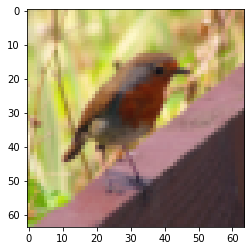

In [20]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [22]:
def predict(X,parameters):
    
    m = X.shape[1]
    y_pred=np.zeros((1,m))
    
    probs, caches = linear_model(X,parameters)
    
    for i in range(len(probs[0])):
        
        if probs[0][i] >= 0.5:
            y_pred[0][i]=1
        
        else:
            y_pred[0][i]=0
    
    return y_pred
    

In [23]:
def accuracy_score_me(y_pred,y_true):
    
    m=y_true.shape[1]
    
    acc=np.sum((y_pred==y_true)) / m
    trues=np.sum((y_pred==y_true))
    
    
    return acc ,trues
    

In [25]:
def confusion_matrix(y_pred,y_true):
    
    true_p=np.sum((y_pred==y_true),where=(y_pred==1))
    true_n=np.sum((y_pred==y_true),where=(y_pred==0))
    false_p=np.sum((y_pred!=y_true),where=(y_pred==1))
    false_n=np.sum((y_pred!=y_true),where=(y_pred==0))
    
    matrix=np.array([true_n,false_p,false_n,true_p]).reshape(2,2)
    df=pd.DataFrame(matrix,index=[0,1],columns=[0,1])
    
    return df

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(pred_y, true_y, title='Confusion Matrix', figsize=(8,6)):
    """ Custom function for plotting a confusion matrix for predicted results """
    conf_matrix = confusion_matrix(pred_y, true_y)
    conf_df = pd.DataFrame(conf_matrix, columns=np.unique(true_y), index = np.unique(true_y))
    conf_df.index.name = 'Actual'
    conf_df.columns.name = 'Predicted'
    plt.figure(figsize = figsize)
    plt.title(title)
    sns.set(font_scale=1.4)
    sns.heatmap(conf_df, cmap="Blues", annot=True, 
                annot_kws={"size": 16}, fmt='g')
    plt.show()
    return



In [24]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [21]:
layers_dims = [12288, 20, 7, 5, 1] 

# Early Stopping

In [31]:
def dnn_model(X, Y, layer_dims, learning_rate=0.0075,iteration=2500,print_cost=False,early_stopping=False,eval_set=[]):
    
    costs=[]
    accuracy_scores=[]
    
    parameters = initialize_parameters(layer_dims)
    
    if early_stopping==False:
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 100 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
    
    
    elif early_stopping==True:
        
        x_eval=eval_set[0]
        y_eval=eval_set[1]
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 100 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost),end="   ")
                
                
                y_pred_test=predict(test_x,parameters)
                accuracy, trues = accuracy_score_me(y_pred_test,test_y)
                
                print("Test set accuracy: %f" %(accuracy))
                
                
            if print_cost and i % 100 == 0:
                costs.append(cost)
                accuracy_scores.append(accuracy)
                
    
          
   
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    plt.plot(np.squeeze(accuracy_scores))
    plt.ylabel('accuracy score for test set')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    
    return parameters

Train cost after iteration 0: 0.682692   Test set accuracy: 0.340000
Train cost after iteration 100: 0.589923   Test set accuracy: 0.420000
Train cost after iteration 200: 0.428584   Test set accuracy: 0.620000
Train cost after iteration 300: 0.390214   Test set accuracy: 0.380000
Train cost after iteration 400: 0.426748   Test set accuracy: 0.820000
Train cost after iteration 500: 0.327314   Test set accuracy: 0.820000
Train cost after iteration 600: 0.264716   Test set accuracy: 0.800000
Train cost after iteration 700: 0.187964   Test set accuracy: 0.700000
Train cost after iteration 800: 0.197943   Test set accuracy: 0.560000
Train cost after iteration 900: 0.143708   Test set accuracy: 0.620000
Train cost after iteration 1000: 0.111242   Test set accuracy: 0.640000
Train cost after iteration 1100: 0.092508   Test set accuracy: 0.640000
Train cost after iteration 1200: 0.079162   Test set accuracy: 0.640000
Train cost after iteration 1300: 0.069150   Test set accuracy: 0.680000
Trai

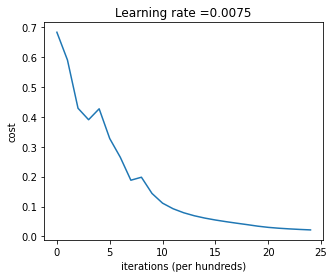

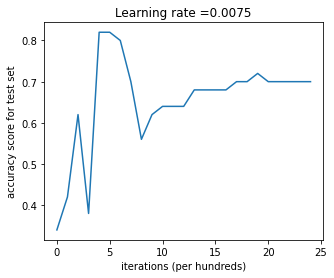

In [34]:
parameters=dnn_model(train_x,train_y,layers_dims,learning_rate=0.0075,iteration=2500,print_cost=True,early_stopping=True,
                    eval_set=[test_x,test_y])

In [35]:
## We determined the best iteration for the highest accuracy score

Train cost after iteration 0: 0.682692   Test set accuracy: 0.340000
Train cost after iteration 100: 0.589923   Test set accuracy: 0.420000
Train cost after iteration 200: 0.428584   Test set accuracy: 0.620000
Train cost after iteration 300: 0.390214   Test set accuracy: 0.380000
Train cost after iteration 400: 0.426748   Test set accuracy: 0.820000


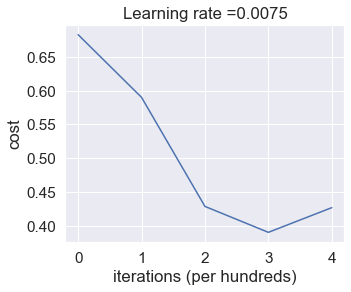

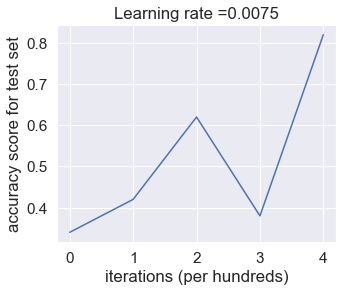

In [73]:
parameters=dnn_model(train_x,train_y,layers_dims,learning_rate=0.0075,iteration=401,print_cost=True,early_stopping=True,
                    eval_set=[test_x,test_y])

In [76]:
y_pred_train=predict(train_x,parameters)
y_pred_test=predict(test_x,parameters)

In [77]:
matrix=confusion_matrix(y_pred_train,train_y)

In [78]:
matrix

,0,1
0,124,13
1,5,67


In [80]:
matrix=confusion_matrix(y_pred_test,test_y)

In [81]:
matrix

,0,1
0,11,6
1,3,30


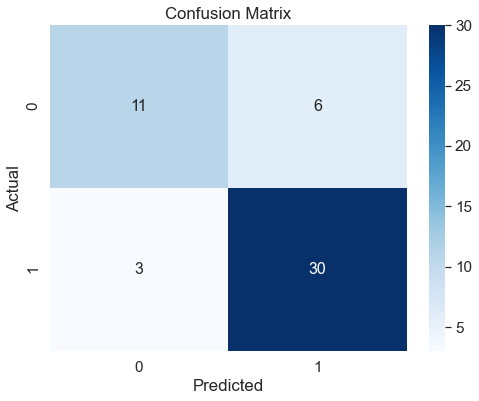

In [82]:
plot_confusion_matrix(y_pred_test,test_y)

In [83]:
accuracy_train, trues_train = accuracy_score_me(y_pred_train,train_y)
accuracy_test, trues_test = accuracy_score_me(y_pred_test,test_y)

print("Accuracy score and #trues of train set:",accuracy_train," ",trues_train)
print("Accuracy score and #trues of test set:",accuracy_test," ",trues_test)


Accuracy score and #trues of train set: 0.9138755980861244   191
Accuracy score and #trues of test set: 0.82   41


In [49]:
###improved the 0.8 test accuracy with early stopping

# Learning Rate Tuning

In [45]:
def dnn_model(X, Y, layer_dims, learning_rate=0.0075, iteration=2500,print_cost=False,early_stopping=False,eval_set=[]):
    
    costs=[]
    accuracy_scores=[]
    
    parameters = initialize_parameters(layer_dims)
    
    if early_stopping==False:
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 100 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
    
    
    elif early_stopping==True:
        
        x_eval=eval_set[0]
        y_eval=eval_set[1]
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)
            
            y_pred_test=predict(test_x,parameters)
            accuracy, trues = accuracy_score_me(y_pred_test,test_y)
            
            if  i % 1 == 0:
                costs.append(cost)
                accuracy_scores.append(accuracy)
            
            if print_cost and i % 1 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost),end="   ")
                print("Test set accuracy: %f" %(accuracy))

            
            if print_cost and (i == iteration-1):
                 
                plt.plot(np.squeeze(costs))
                plt.ylabel('cost')
                plt.xlabel('iterations (per hundreds)')
                plt.title("Learning rate =" + str(learning_rate))
                plt.show()

                plt.plot(np.squeeze(accuracy_scores))
                plt.ylabel('accuracy score for test set')
                plt.xlabel('iterations (per hundreds)')
                plt.title("Learning rate =" + str(learning_rate))
                plt.show()
            
            

    
    return parameters, np.max(accuracy_scores)

In [38]:
def learning_rate_search(learning_rate_grid=[0.0075]):
    max_acc_list=[]
    for lr in learning_rate_grid:
        params,max_acc=dnn_model(train_x, train_y, layers_dims, learning_rate=lr, iteration=500,print_cost=False,early_stopping=True,eval_set=[test_x,test_y])
        max_acc_list.append(max_acc)
    
    max_of_maxes=np.max(max_acc_list)
    ix=max_acc_list.index(max_of_maxes)
    
    return max_of_maxes, learning_rate_grid[ix] 

Train cost after iteration 0: 0.682692   Test set accuracy: 0.340000
Train cost after iteration 100: 0.589923   Test set accuracy: 0.420000
Train cost after iteration 200: 0.428584   Test set accuracy: 0.620000
Train cost after iteration 300: 0.390214   Test set accuracy: 0.380000
Train cost after iteration 400: 0.426748   Test set accuracy: 0.820000
Train cost after iteration 500: 0.327314   Test set accuracy: 0.820000
Train cost after iteration 600: 0.264716   Test set accuracy: 0.800000
Train cost after iteration 700: 0.187964   Test set accuracy: 0.700000
Train cost after iteration 800: 0.197943   Test set accuracy: 0.560000
Train cost after iteration 900: 0.143708   Test set accuracy: 0.620000
Train cost after iteration 1000: 0.111242   Test set accuracy: 0.640000
Train cost after iteration 1100: 0.092508   Test set accuracy: 0.640000
Train cost after iteration 1200: 0.079162   Test set accuracy: 0.640000
Train cost after iteration 1300: 0.069150   Test set accuracy: 0.680000
Trai

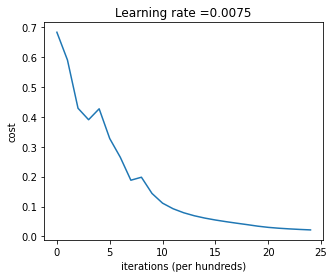

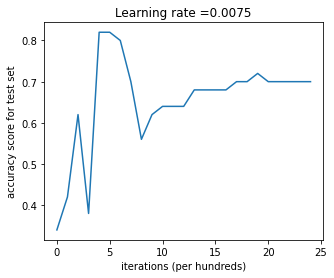

In [40]:
params,max_acc=dnn_model(train_x, train_y, layers_dims, learning_rate=0.0075, iteration=2500,print_cost=True,early_stopping=True,eval_set=[test_x,test_y])

In [41]:
max_of_maxes , learning_rate_tuned = learning_rate_search(learning_rate_grid=[0.0075,0.001,0.01,0.1])

In [43]:
max_of_maxes , learning_rate_tuned

(0.86, 0.01)

In [ ]:
def dnn_model(X, Y, layer_dims, learning_rate=0.0075, iteration=2500,print_cost=False,early_stopping=False,eval_set=[]):
    
    costs=[]
    accuracy_scores=[]
    
    parameters = initialize_parameters(layer_dims)
    
    if early_stopping==False:
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 100 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
    
    
    elif early_stopping==True:
        
        x_eval=eval_set[0]
        y_eval=eval_set[1]
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches)

            parameters = update_parameters(parameters, grads, learning_rate)
            
            y_pred_test=predict(test_x,parameters)
            accuracy, trues = accuracy_score_me(y_pred_test,test_y)
            
            if  i % 1 == 0:
                costs.append(cost)
                accuracy_scores.append(accuracy)
            
            if print_cost and i % 1 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost),end="   ")
                print("Test set accuracy: %f" %(accuracy))

            
            if print_cost and (i == iteration-1):
                 
                plt.plot(np.squeeze(costs))
                plt.ylabel('cost')
                plt.xlabel('iterations (per hundreds)')
                plt.title("Learning rate =" + str(learning_rate))
                plt.show()

                plt.plot(np.squeeze(accuracy_scores))
                plt.ylabel('accuracy score for test set')
                plt.xlabel('iterations (per hundreds)')
                plt.title("Learning rate =" + str(learning_rate))
                plt.show()
            
            

    
    return parameters, np.max(accuracy_scores)

Train cost after iteration 0: 0.682692   Test set accuracy: 0.340000
Train cost after iteration 1: 0.667041   Test set accuracy: 0.340000
Train cost after iteration 2: 0.652729   Test set accuracy: 0.340000
Train cost after iteration 3: 0.648603   Test set accuracy: 0.340000
Train cost after iteration 4: 0.646808   Test set accuracy: 0.340000
Train cost after iteration 5: 0.645508   Test set accuracy: 0.340000
Train cost after iteration 6: 0.644394   Test set accuracy: 0.340000
Train cost after iteration 7: 0.643360   Test set accuracy: 0.340000
Train cost after iteration 8: 0.642354   Test set accuracy: 0.340000
Train cost after iteration 9: 0.641343   Test set accuracy: 0.340000
Train cost after iteration 10: 0.640304   Test set accuracy: 0.340000
Train cost after iteration 11: 0.639220   Test set accuracy: 0.340000
Train cost after iteration 12: 0.638079   Test set accuracy: 0.340000
Train cost after iteration 13: 0.636872   Test set accuracy: 0.340000
Train cost after iteration 14:

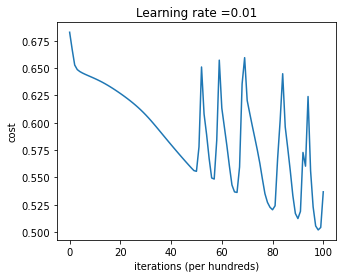

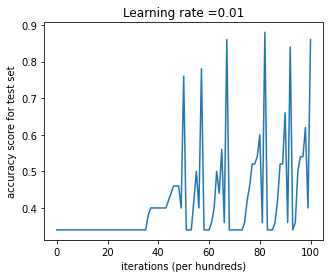

In [47]:
params,max_acc=dnn_model(train_x, train_y, layers_dims, learning_rate=learning_rate_tuned,
                         iteration=101,print_cost=True,early_stopping=True,eval_set=[test_x,test_y])

In [48]:
### This learning rate (0.01) is not reliable since there is no stable raise in "test accuracy" as well as decrease in "train cost"

# Hidden Layer Act Function Preference

In [50]:
def linear_model(X, parameters,act_pref="relu"):
    
    caches=[]
    
    A = X
    L = len(parameters) // 2
    
    for l in range(1,L):
        A_prev=A
        W = parameters["W"+str(l)]
        b= parameters ["b"+str(l)]
        A , cache = linear_act_forward(A_prev,W,b, act_function=act_pref)
        caches.append(cache)
    
    W=parameters["W"+str(L)]
    b=parameters["b"+str(L)]
    AL , cache = linear_act_forward(A,W,b,act_function="sigmoid")
    caches.append(cache)
    
    return AL, caches
    

In [56]:
def backward_model(AL,Y,caches,act_pref="relu"):
    
    grads=dict()
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    L = len(caches)
    
    grads["dW"+str(L)],grads["db"+str(L)],grads["dA"+str(L-1)]=linear_act_backward(dAL,caches[L-1],act_function="sigmoid")
    
    for l in reversed(range(1,L)):
        current_cache=caches[l-1]
        dW_temp,db_temp,dA_temp=linear_act_backward(grads["dA"+str(l)],current_cache,act_function=act_pref)
        grads["dW"+str(l)]=dW_temp
        grads["db"+str(l)]=db_temp
        grads["dA"+str(l-1)]=dA_temp
    
    return grads

In [53]:
def dnn_model(X, Y, layer_dims,
              learning_rate=0.0075,
              iteration=2500,
              print_cost=False,
              act_pref="relu",
              early_stopping=False,
              eval_set=[]):
    
    costs=[]
    accuracy_scores=[]
    
    parameters = initialize_parameters(layer_dims)
    
    if early_stopping==False:
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters,act_pref)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches,act_pref)

            parameters = update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 100 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost))
            if print_cost and i % 100 == 0:
                costs.append(cost)
    
    
    elif early_stopping==True:
        
        x_eval=eval_set[0]
        y_eval=eval_set[1]
        
        for i in range(0,iteration):

            AL, caches = linear_model(X,parameters,act_pref)

            cost = compute_cost(AL, Y)

            grads = backward_model(AL, Y, caches,act_pref)

            parameters = update_parameters(parameters, grads, learning_rate)

            if print_cost and i % 100 == 0:
                print ("Train cost after iteration %i: %f" %(i, cost),end="   ")
                
                
                y_pred_test=predict(test_x,parameters)
                accuracy, trues = accuracy_score_me(y_pred_test,test_y)
                
                print("Test set accuracy: %f" %(accuracy))
                
                
            if print_cost and i % 100 == 0:
                costs.append(cost)
                accuracy_scores.append(accuracy)
                
    
          
   
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    plt.plot(np.squeeze(accuracy_scores))
    plt.ylabel('accuracy score for test set')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    
    return parameters

Train cost after iteration 0: 0.771749   Test set accuracy: 0.540000
Train cost after iteration 100: 0.669270   Test set accuracy: 0.340000
Train cost after iteration 200: 0.638874   Test set accuracy: 0.480000
Train cost after iteration 300: 0.597884   Test set accuracy: 0.380000
Train cost after iteration 400: 0.568827   Test set accuracy: 0.620000
Train cost after iteration 500: 0.461260   Test set accuracy: 0.780000
Train cost after iteration 600: 0.508484   Test set accuracy: 0.640000
Train cost after iteration 700: 0.327596   Test set accuracy: 0.600000
Train cost after iteration 800: 0.310398   Test set accuracy: 0.820000
Train cost after iteration 900: 0.248831   Test set accuracy: 0.780000
Train cost after iteration 1000: 0.207309   Test set accuracy: 0.800000
Train cost after iteration 1100: 0.140485   Test set accuracy: 0.820000
Train cost after iteration 1200: 0.115670   Test set accuracy: 0.840000
Train cost after iteration 1300: 0.099260   Test set accuracy: 0.820000
Trai

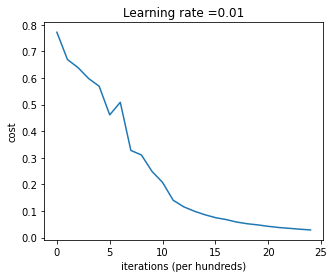

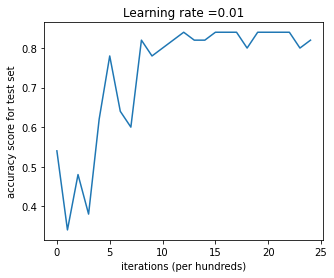

In [57]:
params=dnn_model(train_x, train_y, layers_dims, learning_rate=learning_rate_tuned,
                         iteration=2500,print_cost=True,act_pref="relu",early_stopping=True,eval_set=[test_x,test_y])

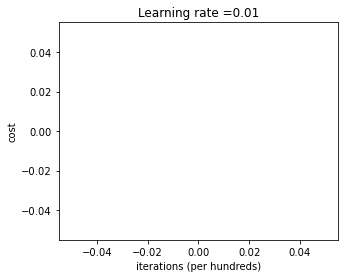

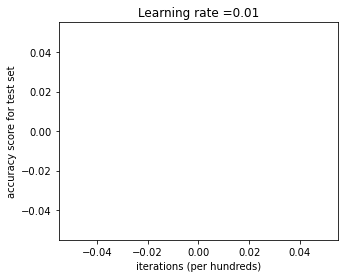

In [58]:
params=dnn_model(train_x, train_y, layers_dims, learning_rate=learning_rate_tuned,
                         iteration=1601,print_cost=False,act_pref="relu",early_stopping=False,eval_set=[test_x,test_y])

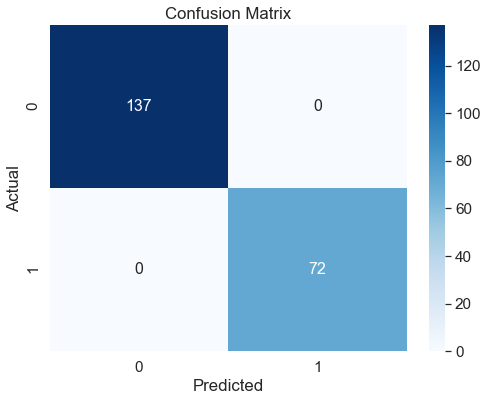

Accuracy Score:  1.0


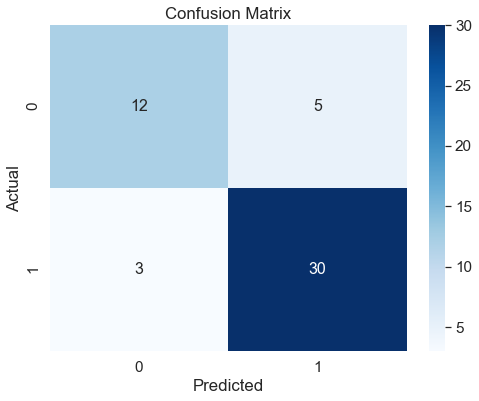

Accuracy Score:  0.84


In [60]:
y_pred_tr=predict(train_x,params)
y_pred_te=predict(test_x,params)

plot_confusion_matrix(y_pred_tr,train_y)
acc, trues = accuracy_score_me(y_pred_tr,train_y)
print("Accuracy Score: ",acc)


plot_confusion_matrix(y_pred_te,test_y)
acc, trues = accuracy_score_me(y_pred_te,test_y)
print("Accuracy Score: ",acc)


In [61]:
### We increased accuracy of test_set and train_set from 0.8 to 0.84 and from 0.98 to 1.00, respectively.